In [1]:
!pip -q install torchinfo

In [2]:
from IPython.display import clear_output
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from pathlib import Path
import os
from torchinfo import summary
import numpy as np

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Data Acquisition

In [4]:
BASE_DIR = Path("./pizza_steak_sushi")
TRAIN_DIR = BASE_DIR / "train"
TEST_DIR = BASE_DIR / "test"

In [5]:
if not BASE_DIR.exists():
    !wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/data/pizza_steak_sushi.zip -O {BASE_DIR}.zip
    !unzip pizza_steak_sushi.zip -d {BASE_DIR}
    clear_output()

# Dataset & DataLoader

In [25]:
train_transforms = transforms.Compose([
    transforms.Resize(size=(64,  64)),
    # transforms.TrivialAugmentWide(),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,  64)),
    transforms.ToTensor()
])

In [26]:
train = datasets.ImageFolder(root=str(TRAIN_DIR), transform=train_transforms)
test = datasets.ImageFolder(root=str(TEST_DIR), transform=test_transforms)

In [27]:
train.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [28]:
BATCH_SIZE = 32

train_dl = DataLoader(dataset=train, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count() or 1)

test_dl = DataLoader(dataset=test, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count() or 1)

# Modelling

In [29]:
class MyVGG(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),

            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),

            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2)

        )

        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=512, out_features=num_classes),
        )

    def forward(self, x):
        return  self.head(self.conv_stack(x))

In [30]:
model = MyVGG(num_classes=3).to(device)
summary(model, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
MyVGG                                    [1, 3]                    --
├─Sequential: 1-1                        [1, 32, 4, 4]             --
│    └─Conv2d: 2-1                       [1, 8, 62, 62]            224
│    └─ReLU: 2-2                         [1, 8, 62, 62]            --
│    └─Conv2d: 2-3                       [1, 8, 60, 60]            584
│    └─ReLU: 2-4                         [1, 8, 60, 60]            --
│    └─MaxPool2d: 2-5                    [1, 8, 30, 30]            --
│    └─Conv2d: 2-6                       [1, 16, 28, 28]           1,168
│    └─ReLU: 2-7                         [1, 16, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 16, 26, 26]           2,320
│    └─ReLU: 2-9                         [1, 16, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 16, 13, 13]           --
│    └─Conv2d: 2-11                      [1, 32, 11, 11]           4,640
│   

# Training

In [31]:
def fit(model: nn.Module, dl: DataLoader, optim: torch.optim.Optimizer, criterion: nn.Module, epochs=2):
    train_loss = []

    for epoch in range(epochs):
        model.train()

        batch_loss = []
        batch_acc = []

        for i, (x, y) in enumerate(dl):

            x, y = x.to(device), y.to(device)

            out = model(x)
            loss = criterion(out, y)

            batch_loss.append(loss.item())

            # accuracy calculation
            acc = (torch.softmax(out, dim=1).argmax(dim=1) == y).sum() / len(y)
            batch_acc.append(acc.item())

            optim.zero_grad()
            loss.backward()
            optim.step()

        epoch_loss = np.mean(np.array(batch_loss))
        epoch_accuracy = np.mean(np.array(batch_acc))

        train_loss.append(epoch_loss)

        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs} | Loss: {epoch_loss} | Accruacy: {epoch_accuracy}")

    return train_loss

In [32]:
def plot_hist(train_loss):
    plt.figure(figsize=(10,5))
    plt.plot(train_loss)
    plt.legend(["Train"])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

In [33]:
LR = 1e-4
EPOCHS = 100

model = MyVGG(num_classes=3).to(device)

optimizer = torch.optim.Adam(lr=LR, params=model.parameters())
criterion = nn.CrossEntropyLoss()

In [34]:
hist = fit(model, train_dl, optimizer, criterion, epochs=EPOCHS)

Epoch 0/100 | Loss: 1.0959466397762299 | Accruacy: 0.4140625
Epoch 10/100 | Loss: 1.097434088587761 | Accruacy: 0.4375
Epoch 20/100 | Loss: 1.0997300148010254 | Accruacy: 0.29296875
Epoch 30/100 | Loss: 1.0880385041236877 | Accruacy: 0.4375
Epoch 40/100 | Loss: 1.053534746170044 | Accruacy: 0.4921875
Epoch 50/100 | Loss: 1.0525263249874115 | Accruacy: 0.5234375
Epoch 60/100 | Loss: 0.879256121814251 | Accruacy: 0.515625
Epoch 70/100 | Loss: 0.7782451938837767 | Accruacy: 0.640625
Epoch 80/100 | Loss: 0.8805475831031799 | Accruacy: 0.5390625
Epoch 90/100 | Loss: 0.8187634944915771 | Accruacy: 0.67578125


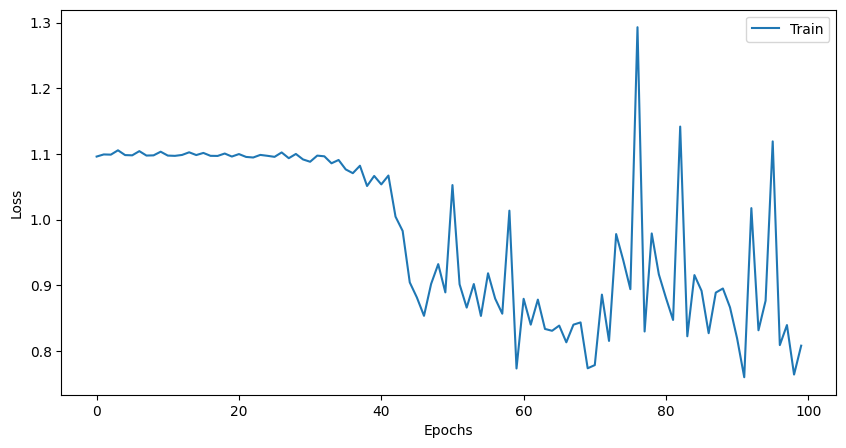

In [35]:
plot_hist(hist)